In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv(r'C:\Users\hh4678\Desktop\DS ML\Fremont Bridge\Fremont_Bridge_Hourly_Bicycle_Counts_by_Month_October_2012_to_present.csv', index_col='Date', parse_dates=True)

data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [3]:
data.columns = ['East', 'West']

In [4]:
data['Total'] = data.eval('West + East')
data.dropna().describe()

,East,West,Total
count,54735.000000,54735.000000,54735.000000
mean,52.619530,58.300850,110.920380
std,68.034365,84.733147,140.018123
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,29.000000,60.000000
75%,70.000000,70.000000,144.000000
max,698.000000,717.000000,957.000000


In [5]:
data.head()

,East,West,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


Text(0,0.5,'Hourly Bicycle Count')

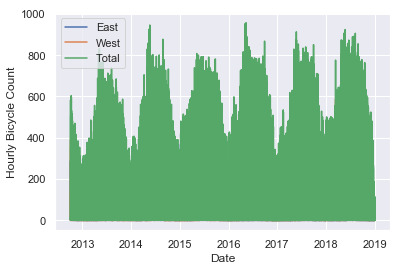

In [6]:
%matplotlib inline
import seaborn; seaborn.set()

data.plot()
plt.ylabel('Hourly Bicycle Count')

Text(0,0.5,'Weekly bicycle count')

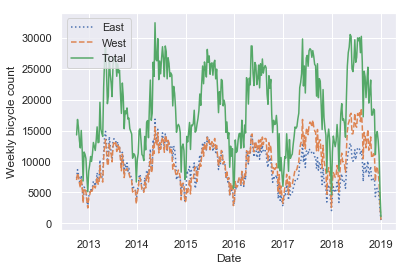

In [7]:
# Aggregate data by week for a clearer plot
# to see if there is seasonality

weekly = data.resample('W').sum()

weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')

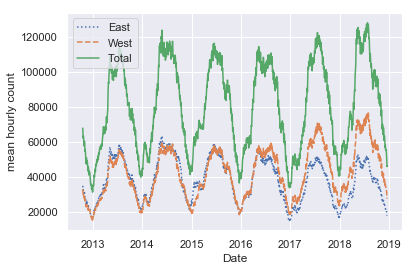

In [8]:
# Aggregate data every 30 days (rolling mean)
# to see if there is consistency 

daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count');

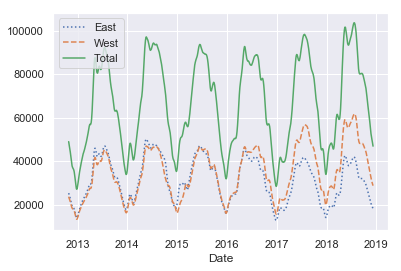

In [9]:
# use Gaussian win-type to alleviate jaggedness

daily.rolling(50, center=True, win_type='gaussian').sum(std=10).plot(style=[':', '--', '-'])

# where 50 is the width of the window (days)
# and 10 is the width of the Gaussian within the window (days)

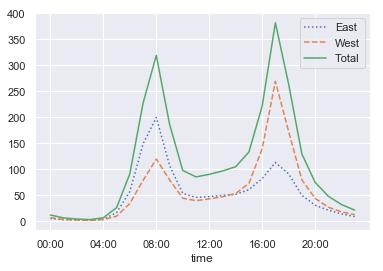

In [10]:
# Let's look at the average traffic as a function of the time of day

by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

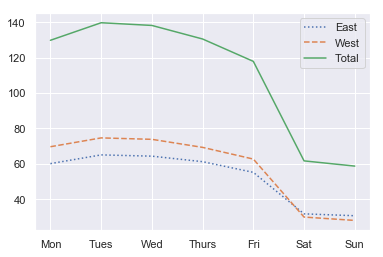

In [11]:
# Let's group the data by day of the week

by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(xticks=[0, 1, 2, 3, 4, 5, 6], style=[':', '--', '-']);

In [12]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

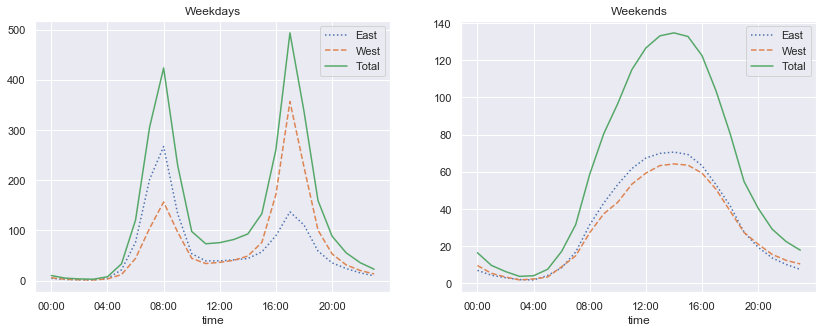

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=[':', '--', '-'])

## Predicting Bicycle Traffic

In [14]:
daily.head()

,East,West,Total
Date,,,
2012-10-03,1760.0,1761.0,3521.0
2012-10-04,1708.0,1767.0,3475.0
2012-10-05,1558.0,1590.0,3148.0
2012-10-06,1080.0,926.0,2006.0
2012-10-07,1191.0,951.0,2142.0


In [15]:
import pandas as pd

counts = pd.read_csv(r'C:\Users\hh4678\Desktop\DS ML\Fremont Bridge\Fremont_Bridge_Hourly_Bicycle_Counts_by_Month_October_2012_to_present.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv(r'C:\Users\hh4678\Desktop\DS ML\Fremont Bridge\BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [16]:
weather[['PRCP', 'TMAX', 'TMIN']].isnull().any()

PRCP    False
TMAX    False
TMIN    False
dtype: bool

In [17]:
# Compute total bicycle traffic
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

In [18]:
# Determine day of the week per index value
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [19]:
# How many years are in our dataset?
s = daily.index.to_series().astype(str)
# print(s[s.str.contains('10-03')])

# A more accurate way is to use set()
# this alleviates having to check each month

unique_years = [i[1].split('-')[0] for i in s.iteritems()]
print(sorted(set(unique_years)))

['2012', '2013', '2014', '2015', '2016', '2017', '2018']


In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2018')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

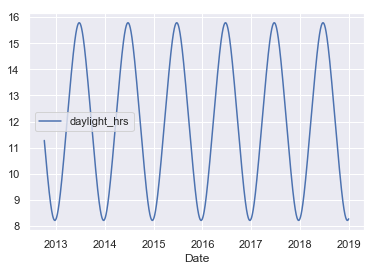

In [21]:
# Determine the hours of daylight - this may affect riders
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date."""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
        * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();

In [22]:
# Determine the average temperature and precipitation

# Temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# Precipitation is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
daily['annual'] = (daily.index - daily.index[0]).days / 365.

daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [23]:
# We don't have weather data after '2015-09-01'

# We can check this by slicing
# daily.loc[~(daily['PRCP'].isnull())]

daily = daily.loc[~(daily['PRCP'].isnull())]

In [25]:
# Let's fit a Linear Regression model to our data

from sklearn.linear_model import LinearRegression

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']
model = LinearRegression(fit_intercept=False) #False since daily flags operate as own day specific intercepts
model.fit(X, y)
daily['predicted'] = model.predict(X)

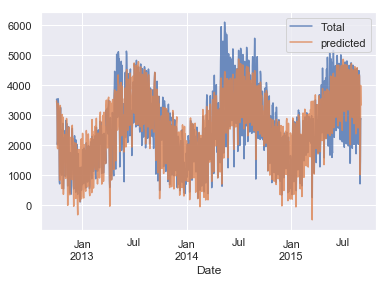

In [29]:
daily[['Total', 'predicted']].plot(alpha=0.8);

In [31]:
# Let's take a look at the coefficients of the linear model

params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

In [32]:
# We can compute these uncertainties quickly using bootstrap resamplings of the data

from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
             for i in range(1000)], 0)

print(pd.DataFrame({'effect' : params.round(0),
                   'error' : err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0
